In [1]:
FILE_LIST = 'files.p'
DATA_DIR = "/run/media/maciej/Nowy/data/json/"
CHOSEN_YEAR = "2011"

In [202]:
import os, json, pickle, sys, os, glob, time
from collections import defaultdict, Counter
from urllib.request import urlopen, Request
from xml.etree import ElementTree


from tqdm import tqdm
import regex

from clarin import process
from visualizations import plot_counter

In [126]:
def get_first_k_judgments(k=100):
    files = pickle.load(open(FILE_LIST, 'rb'))

    total_judgments = []
    for file in tqdm(files):
        if file.startswith("judgment"):
            file_path = os.path.join(DATA_DIR, file)

            with open(file_path, 'r') as f:
                data = json.load(f)
                judgments = [
                    (x["id"], x["judgmentDate"]) for x in data["items"] 
                    if x["judgmentDate"].startswith(CHOSEN_YEAR)
                ]
            total_judgments += judgments

    sorted_by_dates = sorted(total_judgments, key=lambda x: x[1])
    ids, _ = zip(*sorted_by_dates)
    
    return ids[:k]

first_100 = get_first_k_judgments()

100%|██████████| 68/68 [00:01<00:00, 55.16it/s]


In [127]:
word_pattern = "\p{Letter}+"

def load_data(ids):
    total_judgments = []
    files = pickle.load(open(FILE_LIST, 'rb'))
    
    for file in files:
        if file.startswith("judgment"):
            file_path = os.path.join(DATA_DIR, file)

            with open(file_path, 'r') as f:
                data = json.load(f)
                judgments = [
                    x["textContent"] for x in data["items"] 
                    if x["id"] in ids
                ]
                
            total_judgments += judgments
            
    filtered_judgments = []
    for judgment in tqdm(total_judgments):
        judgment = regex.sub("<.*?>", "", judgment)
        judgment = regex.sub("-\n(\p{Letter}+)", r"\1", judgment)
        
        filtered_judgments.append(judgment)
        
    
    return filtered_judgments

judgments = load_data(first_100)

100%|██████████| 100/100 [00:00<00:00, 4950.96it/s]


In [ ]:
# processed_judgments = []
# for judgment in judgments:
#     processed_judgment = process(judgment)
#     if processed_judgment:
#         processed_judgments.append(processed_judgment)
#     else:
#         print(processed_judgment)

In [ ]:
# with open('processed.p', 'wb') as f:
#     pickle.dump(processed_judgments, f)

In [205]:
processed_judgments = pickle.load(open('processed2.p', 'rb'))

In [206]:
parsed = [ElementTree.fromstring(xml) for xml in processed_judgments]

In [207]:
expressions = []
for judgment in parsed:
    for tok in judgment.iter():
        if tok.tag == 'tok':
            text = None

            for elem in tok:
                if elem.tag == 'orth':
                    text = elem.text
                elif elem.tag == 'ann' and elem.text != '0':
                    cat_detailed = elem.attrib['chan']
                    cat_general = "_".join(cat_detailed.split('_')[:2])
                    expressions.append((text, cat_general, cat_detailed))


In [214]:
general = [exp[1] for exp in expressions]
counter_gen = Counter(general)
plot_counter(counter_gen)

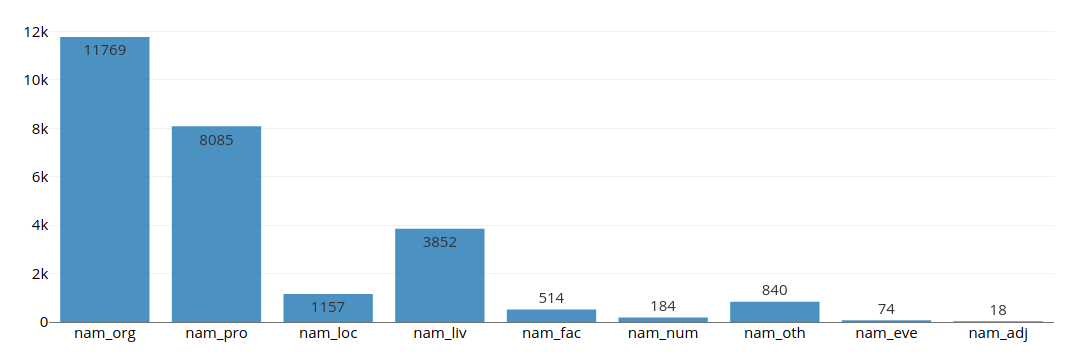

In [215]:
detailed = [exp[2] for exp in expressions]
detailed_counter = Counter(detailed)
plot_counter(detailed_counter)

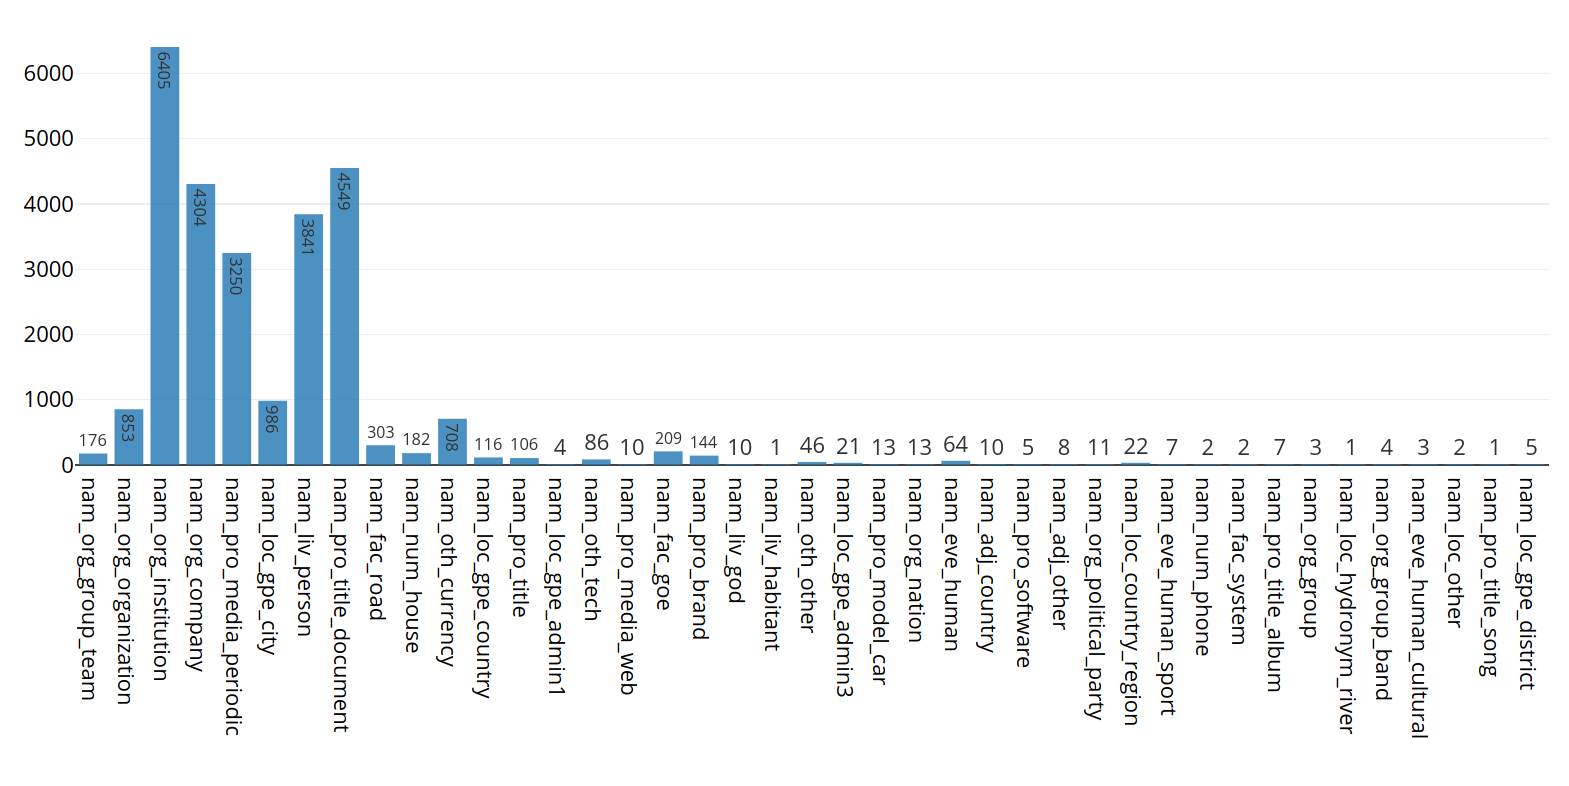

In [210]:
reduced_expressions = Counter(expressions)
sorted_red_exp = sorted(reduced_expressions.items(), key=lambda x: x[1], reverse=True)[:100]
for data, count in sorted_red_exp:
    text, _, cat_detailed = data
    print("{} -> {} {}".format(text.ljust(15), str(count).ljust(5), cat_detailed))

.               -> 1549  nam_pro_media_periodic
.               -> 947   nam_org_company
Dz              -> 779   nam_pro_media_periodic
U               -> 776   nam_pro_media_periodic
Sąd             -> 565   nam_org_institution
zł              -> 519   nam_oth_currency
Sądu            -> 461   nam_org_institution
o               -> 376   nam_org_company
.               -> 352   nam_liv_person
Prawo           -> 297   nam_pro_title_document
o               -> 262   nam_pro_title_document
ustawy          -> 243   nam_pro_title_document
Sp              -> 241   nam_org_company
z               -> 219   nam_org_company
z               -> 213   nam_pro_title_document
dnia            -> 205   nam_pro_title_document
Zamawiającego   -> 202   nam_liv_person
S               -> 202   nam_org_company
A               -> 190   nam_org_company
Prezesa         -> 184   nam_org_institution
M               -> 183   nam_liv_person
zamówień        -> 181   nam_pro_title_document
publicznych     -> 181   

In [211]:
exp_per_general = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
for text, cat_general, cat_detailed in expressions:
    exp_per_general[cat_general][cat_detailed][text] += 1 


In [212]:
for cat_gen, exp_per_det in exp_per_general.items():
    items = [(count, text, cat_det) for cat_det, y in exp_per_det.items() for text, count in y.items()]
    sorted_items = sorted(items, reverse=True)
    print(cat_gen)
    for item in sorted_items[:10]:
        print("\t{}".format(item))


nam_org
	(947, '.', 'nam_org_company')
	(565, 'Sąd', 'nam_org_institution')
	(461, 'Sądu', 'nam_org_institution')
	(376, 'o', 'nam_org_company')
	(241, 'Sp', 'nam_org_company')
	(219, 'z', 'nam_org_company')
	(202, 'S', 'nam_org_company')
	(190, 'A', 'nam_org_company')
	(184, 'Prezesa', 'nam_org_institution')
	(166, 'Okręgowy', 'nam_org_institution')
nam_pro
	(1549, '.', 'nam_pro_media_periodic')
	(779, 'Dz', 'nam_pro_media_periodic')
	(776, 'U', 'nam_pro_media_periodic')
	(297, 'Prawo', 'nam_pro_title_document')
	(262, 'o', 'nam_pro_title_document')
	(243, 'ustawy', 'nam_pro_title_document')
	(213, 'z', 'nam_pro_title_document')
	(205, 'dnia', 'nam_pro_title_document')
	(181, 'zamówień', 'nam_pro_title_document')
	(181, 'publicznych', 'nam_pro_title_document')
nam_loc
	(128, 'Warszawie', 'nam_loc_gpe_city')
	(109, 'Warszawa', 'nam_loc_gpe_city')
	(32, 'Izby', 'nam_loc_gpe_city')
	(31, 'Wrocławiu', 'nam_loc_gpe_city')
	(27, 'Wrocław', 'nam_loc_gpe_city')
	(27, 'Krakowie', 'nam_loc_gpe_